In [1]:
from array import array
import numpy as np
from numpy.random import RandomState
import matplotlib.pyplot as plt
from root_numpy.tmva import add_classification_events, evaluate_reader
from ROOT import TMVA, TFile, TCut

Welcome to ROOTaaS 6.05/02


In [2]:
# Classify the test dataset with the classifier
reader = TMVA.Reader()

Start processing training bin:  EE_10
(132450, 23)
(132450, 21)
[ 0.  1.  0. ...,  0.  1.  0.]


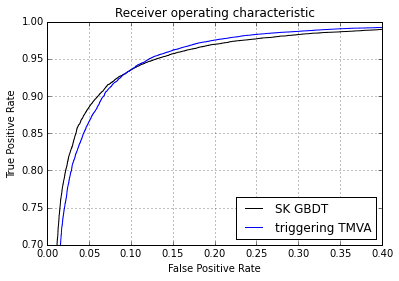

In [5]:
#%pylab inline
%matplotlib inline
from array import array
import numpy as np
from numpy.random import RandomState
import matplotlib.pyplot as plt
from root_numpy.tmva import add_classification_events, evaluate_reader
from ROOT import TMVA, TFile, TCut
# Classify the test dataset with the classifier
reader = TMVA.Reader()
from root_numpy import root2array, rec2array
from sklearn.metrics import roc_curve, auc
from sklearn.metrics.ranking import _binary_clf_curve
from sklearn import grid_search
#import sklearn as sklearn_

BDT_var_names = ['ele_oldsigmaietaieta', 'ele_oldsigmaiphiiphi', 'ele_oldcircularity', 'ele_oldr9', 'ele_scletawidth', 
                 'ele_sclphiwidth', 'ele_he', 'ele_psEoverEraw', 'ele_kfhits', 'ele_kfchi2', 'ele_gsfchi2', 'ele_fbrem',
                 'ele_gsfhits', 'ele_expected_inner_hits', 'ele_conversionVertexFitProbability', 'ele_ep', 'ele_eelepout',
                 'ele_IoEmIop', 'ele_deltaetain', 'ele_deltaphiin', 'ele_deltaetaseed']

BDT_spec_names = ['ele_pT', 'ele_isbarrel', 'ele_isendcap', 'scl_eta', 'ele_eClass', 'ele_pfRelIso', 'ele_expected_inner_hits',
                  'ele_vtxconv', 'mc_event_weight', 'mc_ele_CBmatching_category']


BDT_train_bins = ['EE_10']#, 'EB1_10', 'EB2_10']


weight_postfix = '_oldNonTrigSpring15_ConvVarCwoBoolean_TMVA412_FullStatLowPt_PairNegWeightsGlobal_BDT.weights.xml'
weight_prefix = '/Users/pigard/CMS/comparison/properTrainings/NonTrigSpring15_ConvVarCwoBoolean_TMVA412_FullStatLowPt_PairNegWeightsGlobal/weights/EIDmva_'

tree_prefix = '/Users/pigard/CMS/MVA_dev/TriggeringSelectionStudy/properTrainings/TMVA_'
tree_postfix = '_oldTrigSpring15_25ns_data_1_VarD_TMVA412_Sig6BkgAll_MG_noSpec.root'

isEE = False


def f5(seq, idfun=None): 
   # order preserving
   if idfun is None:
       def idfun(x): return x
   seen = {}
   result = []
   for item in seq:
       marker = idfun(item)
       # in old Python versions:
       # if seen.has_key(marker)
       # but in new ones:
       if marker in seen: continue
       seen[marker] = 1
       result.append(item)
   return result

#tree_vars = f5(tree_vars)           
    

for b in BDT_train_bins :
    reader = TMVA.Reader()
    print 'Start processing training bin: ', b
    
    isEE = False
    nVars = 20
    if b.find('EE') > -1 :
        isEE = True
        
    if isEE:
        nVars = 21 
    else :
        BDT_var_names = [var for var in BDT_var_names if 'ele_psEoverEraw' != var]

    tree_vars = BDT_var_names + ['BDT', 'classID']
    
    test_tree = root2array(tree_prefix + b + tree_postfix, "TestTree", tree_vars)
    train_tree = root2array(tree_prefix + b + tree_postfix, "TrainTree", tree_vars)
    
    test_tree = rec2array(test_tree)
    train_tree = rec2array(train_tree)
    
    full = np.concatenate((test_tree, train_tree))
    print np.shape(full)
    X = full[:,:nVars]
    print np.shape(X)
    
    Y = full[:,nVars + 1]
    print Y
    
    from sklearn.cross_validation import train_test_split
    
    X_train,X_test, y_train,y_test = train_test_split(X, Y,
                                                  test_size=0.5, random_state=492)
    
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
    from sklearn.metrics import classification_report, roc_auc_score

    
    
    #  NTrees=2000:BoostType=Grad:Shrinkage=0.10:!UseBaggedGrad:nCuts=2000:nEventsMin=100:NNodesMax=5:UseNvars=4:PruneStrength=5:PruneMethod=CostComplexity:MaxDepth=6:NegWeightTreatment=PairNegWeightsGlobal:CreateMVAPdfs");
    
    #param_grid = [
    #  {'n_estimators': [800, 1000, 1200, 1400, 2000, 2200], 'learning_rate': [0.08, .1, .12], 'max_depth' : [4, 5, 6, 7]}
    #]

    param_grid = [
      {'n_estimators': [2000], 'learning_rate': [.1], 'max_depth' : [6]}
    ]
    
    gbdt_grid = grid_search.GridSearchCV(GradientBoostingClassifier(), param_grid)
    gbdt_grid.fit(X_train, y_train)
    
    gbdt = gbdt_grid.best_estimator_
    
    #gbdt = GradientBoostingClassifier(n_estimators=2000, learning_rate =.1, max_depth=6, random_state=0)
 
    
    #gbdt.fit(X_train, y_train)
    
    
    tree = root2array(tree_prefix + b + tree_postfix, "TestTree", tree_vars)
    classID = [ x['classID'] for x in tree]
    data = []
    BDT_val = []
    for n in range(len(tree)) :
        row = tree[n]
        row_l = [var for var in row]
        data.append(row_l[:nVars])

    BDT = tree['BDT']
    BDT_val = BDT
    

    fpr, tpr, thresholds = roc_curve(classID, BDT_val, pos_label = 0.)

    
    gbdt_decisions = gbdt.decision_function(X_test)
    # Compute ROC curve and area under the curve
    gbd_f, gbd_t, thresholds = roc_curve(y_test, gbdt_decisions, pos_label = 1)
    
    #plt.plot(bd_f, bd_t, lw=1, color=(0.0, 0.0, 1.0), label='SK DT')
    plt.plot(gbd_f, gbd_t, lw=1, color='black', label='SK GBDT')
    plt.plot(fpr, tpr, lw=1, label='triggering TMVA')
    #plt.plot(fpr_sel, tpr_sel, lw=1, color=(1.0, 0.0, 0.0), label='non-triggering (area = %0.2f)'%(roc_auc_sel))


    #plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
    plt.xlim([0.0, 0.4])
    plt.ylim([0.7, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()


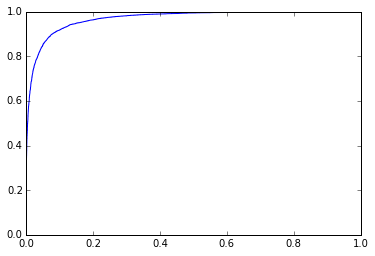

[ 0.  0.  0. ...,  1.  0.  0.]
[-0.20666751 -0.05540844 -0.23668484 ...,  0.18726374 -0.21657067
 -0.14561063]


In [29]:


bd_f, bd_t, thresholds = roc_curve(y_test, decisions, pos_label = 1.)
plt.plot(bd_f, bd_t, lw=1, color=(0.0, 0.0, 1.0), label='SK DT')
plt.show()
print y_test
print decisions

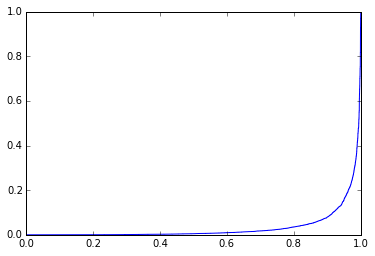

In [19]:
print np.shape(X_train)

(59456, 21)


NameError: name 'gbdt' is not defined

In [8]:
gbdt2 = GradientBoostingClassifier(n_estimators=800, learning_rate =.1, max_depth=6, random_state=0)
 
gbdt2.fit(X_train, y_train)  
    
    #factory->BookMethod(TMVA::Types::kBDT, "BDT",
   #           "!H:!V:NTrees=2000:BoostType=Grad:Shrinkage=0.10:!UseBaggedGrad:nCuts=2000:nEventsMin=100:NNodesMax=5:UseNvars=4:PruneStrength=5:PruneMethod=CostComplexity:MaxDepth=6:NegWeightTreatment=PairNegWeightsGlobal:CreateMVAPdfs");

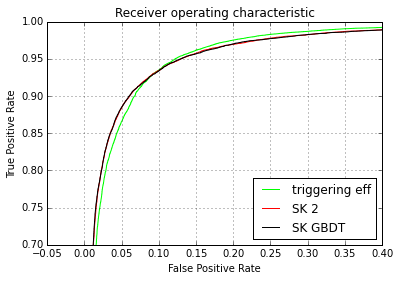

In [9]:
    gbdt_decisions = gbdt.decision_function(X_test)
    # Compute ROC curve and area under the curve
    gbd_f, gbd_t, thresholds = roc_curve(y_test, gbdt_decisions, pos_label = 1)
    gbdt2_decisions = gbdt2.decision_function(X_test)
    # Compute ROC curve and area under the curve
    gbd2_f, gbd2_t, thresholds = roc_curve(y_test, gbdt2_decisions, pos_label = 1)
    
    plt.plot(beff, seff, lw=1, color=(0.0, 1.0, 0.0), label='triggering eff')
    plt.plot(gbd2_f, gbd2_t, lw=1, color='red', label='SK 2')
    plt.plot(gbd_f, gbd_t, lw=1, color='black', label='SK GBDT')
    #plt.plot(fpr, tpr, lw=1, label='triggering (area = %0.2f)'%(roc_auc))
    #plt.plot(fpr_sel, tpr_sel, lw=1, color=(1.0, 0.0, 0.0), label='non-triggering (area = %0.2f)'%(roc_auc_sel))


    #plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
    plt.xlim([-0.05, 0.4])
    plt.ylim([0.7, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()